In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, GRU, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('C:\\Users\\meera\\Documents\\BTech CSE spl. AIML\\VS code\\CADS Internship\\Turbine Dataset SCADA.csv')
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format='%d %m %Y %H:%M')
data.set_index('Date/Time', inplace=True)

In [3]:
# Feature selection
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = 'LV ActivePower (kW)'

In [4]:
# Handle missing values
data.dropna(inplace=True)

# Detect and handle outliers using clipping
def clip_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Clipping outliers in features and target
for col in features + [target]:
    clip_outliers(data, col)

In [5]:
# Normalize the data
scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

In [6]:
# Convert to supervised learning problem
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Example sequence length (e.g., 24 hours)
X, y = create_sequences(data[features].values, data[target].values, seq_length)

In [7]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# LSTM + GRU Model definition
input_layer = Input(shape=(seq_length, len(features)))
lstm_layer = LSTM(50, return_sequences=True)(input_layer)
gru_layer = GRU(50, return_sequences=False)(lstm_layer)
dense_layer = Dense(25, activation='relu')(gru_layer)
output_layer = Dense(1)(dense_layer)

lstm_gru_model = Model(inputs=input_layer, outputs=output_layer)
lstm_gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Model training
lstm_gru_history = lstm_gru_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1011/1011 [==============================] - 21s 18ms/step - loss: 0.0214 - val_loss: 0.0085
Epoch 2/10
1011/1011 [==============================] - 18s 18ms/step - loss: 0.0181 - val_loss: 0.0096
Epoch 3/10
1011/1011 [==============================] - 19s 19ms/step - loss: 0.0179 - val_loss: 0.0068
Epoch 4/10
1011/1011 [==============================] - 20s 20ms/step - loss: 0.0176 - val_loss: 0.0064
Epoch 5/10
1011/1011 [==============================] - 20s 20ms/step - loss: 0.0176 - val_loss: 0.0094
Epoch 6/10
1011/1011 [==============================] - 20s 20ms/step - loss: 0.0173 - val_loss: 0.0069
Epoch 7/10
1011/1011 [==============================] - 21s 21ms/step - loss: 0.0171 - val_loss: 0.0062
Epoch 8/10
1011/1011 [==============================] - 21s 21ms/step - loss: 0.0169 - val_loss: 0.0129
Epoch 9/10
1011/1011 [==============================] - 20s 20ms/step - loss: 0.0166 - val_loss: 0.0096
Epoch 10/10
1011/1011 [==============================] - 21s 21m

In [10]:
# Model evaluation
lstm_gru_predicted = lstm_gru_model.predict(X_test)

316/316 [==============================] - 3s 6ms/step


In [11]:
# Checking for small actual values
small_value_threshold = 0.01
small_values = np.sum(y_test < small_value_threshold)
total_values = len(y_test)
print(f'Number of small actual values (< {small_value_threshold}): {small_values} out of {total_values}')

# Handling negative predictions by setting them to zero
lstm_gru_predicted = np.maximum(lstm_gru_predicted, 0)

Number of small actual values (< 0.01): 2255 out of 10102


In [13]:
# Checking for small actual values
small_value_threshold = 0.01
small_values = np.sum(y_test < small_value_threshold)
total_values = len(y_test)
print(f'Number of small actual values (< {small_value_threshold}): {small_values} out of {total_values}')

# Handling negative predictions by setting them to zero
lstm_gru_predicted = np.maximum(lstm_gru_predicted, 0)

Number of small actual values (< 0.01): 2255 out of 10102


In [16]:
# Evaluation metrics
mse = mean_squared_error(y_test, lstm_gru_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_gru_predicted)
r2 = r2_score(y_test, lstm_gru_predicted)
msle = mean_squared_log_error(y_test, lstm_gru_predicted)

In [17]:
# Output the results
print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Model Evaluation Metrics:
Mean Squared Error (MSE): 0.03204642067862079
Root Mean Squared Error (RMSE): 0.17901514092003723
Mean Absolute Error (MAE): 0.09174552174214386
R-squared (R²): 0.7689276684912358
Mean Squared Logarithmic Error (MSLE): 0.015332834656963331


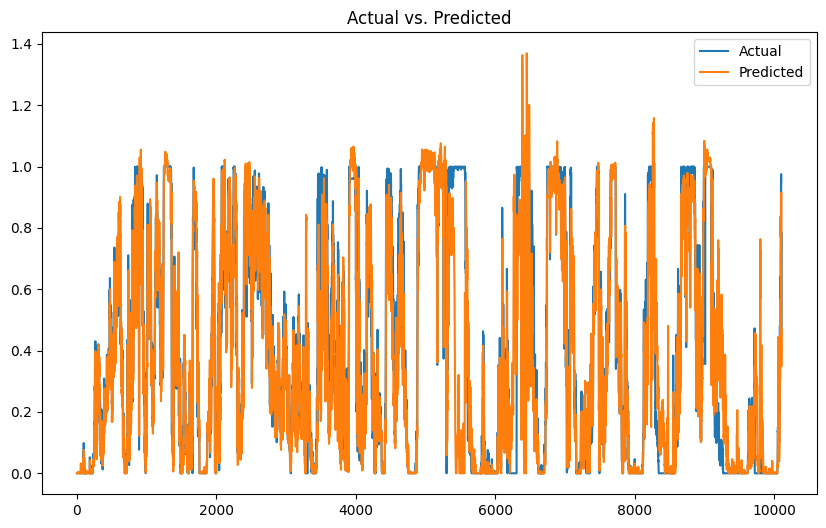

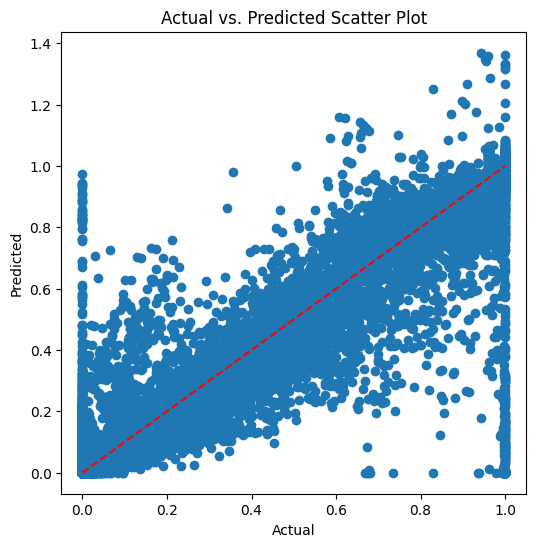

In [18]:
# Visualizing results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_gru_predicted, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, lstm_gru_predicted)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Scatter Plot')
plt.show()

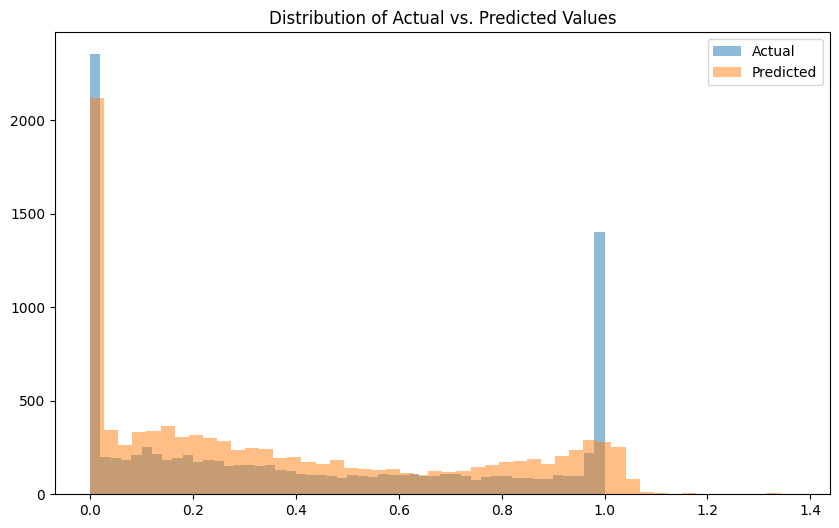

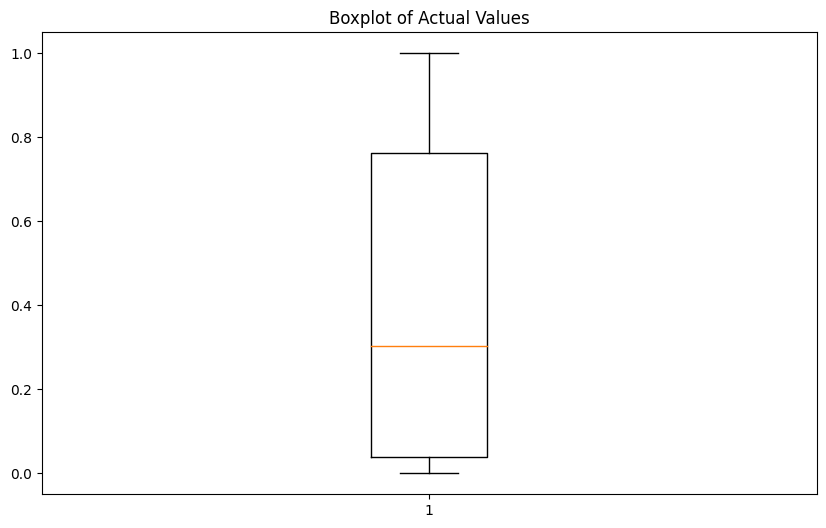

In [19]:
# Checking the distribution of actual and predicted values
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label='Actual')
plt.hist(lstm_gru_predicted, bins=50, alpha=0.5, label='Predicted')
plt.legend()
plt.title('Distribution of Actual vs. Predicted Values')
plt.show()

# Checking for outliers in the actual values
plt.figure(figsize=(10, 6))
plt.boxplot(y_test)
plt.title('Boxplot of Actual Values')
plt.show()

Negative values in inverse transformed y_test: False
Negative values in inverse transformed lstm_predicted: False


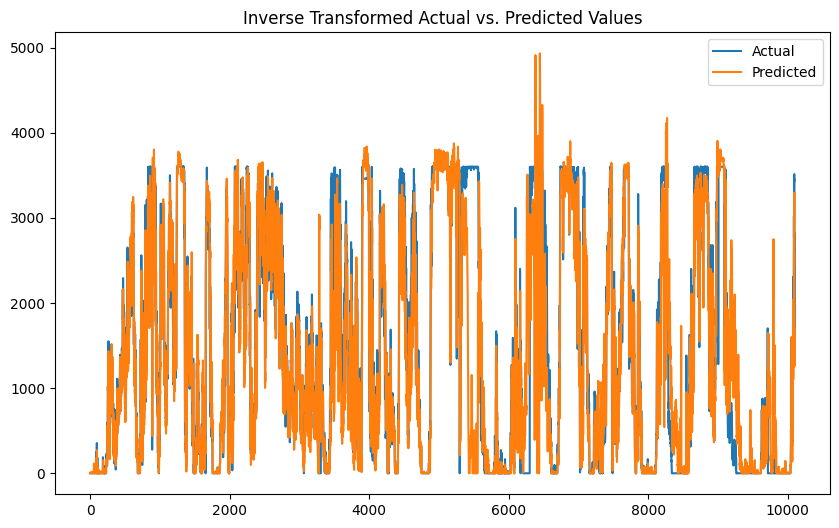

In [22]:
# Inverse transform the target variable if it was scaled
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)], axis=1))[:, -1]
lstm_predicted_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(lstm_gru_predicted), len(features))), lstm_gru_predicted.reshape(-1, 1)], axis=1))[:, -1]

# Checking for negative values in the inverse transformed predictions
print(f'Negative values in inverse transformed y_test: {np.any(y_test_inv < 0)}')
print(f'Negative values in inverse transformed lstm_predicted: {np.any(lstm_predicted_inv < 0)}')

# Visualizing the inverse transformed actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_predicted_inv, label='Predicted')
plt.legend()
plt.title('Inverse Transformed Actual vs. Predicted Values')
plt.show()